In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys
from train_GMM import get_points_in_box
from sklearn.cluster import KMeans
# sys.path.append("/tf/home/repositorios/DMAE/") # how to use the code in other location
sys.path.append("../../DMAE")
sys.path.append("../../DMAE/examples/synthetic")
import DMAE
import vis_utils

/home/vladimir/.local/share/virtualenvs/GMM-EM_LiebLiniger-CJETMew8/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


(2236, 2)


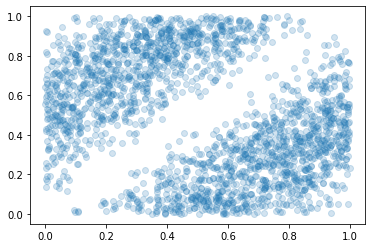

In [2]:
# Number of samples to generate
X = np.load("particle_positions_N=2_metro_steps=1000000.npz").T
idx = np.arange(X.shape[0])
np.random.shuffle(idx)
X = X[idx][:20000]
X = get_points_in_box(X, 1)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
print(X.shape)

In [4]:
# Number of clusters
n_clusters = 2
# Softmax inverse temperature parameter
alpha = 100
# Training parameters
batch_size = 256
epochs = 200
lr = 1e-4

In [5]:
def toroidal_dis(x_i, Y, bounds=(1.0, 1.0)):
    d = [tf.reshape(tf.reduce_sum((x_i-Y)**2, axis=1), (-1, 1))]
    for i, val in enumerate(bounds):
        delta = tf.one_hot([i], depth=len(bounds))*val
        d.append(tf.reshape(tf.reduce_sum((x_i-Y-delta)**2, axis=1), (-1, 1)))
        d.append(tf.reshape(tf.reduce_sum((x_i-Y+delta)**2, axis=1), (-1, 1)))
    
    print(delta)
    print(d[0])
    print(d[1])
    d = tf.concat(d, axis=1)
    return tf.reduce_min(d, axis=1)

def toroidal_pairwise(X, Y, bounds=(1.0, 1.0)):
    func = lambda x_i: toroidal_dis(x_i, Y, bounds)
    Z = tf.vectorized_map(func, X)
    return Z

def toroidal_loss(X, mu_tilde, bounds=(1.0, 1.0)):
    d = [tf.reshape(tf.reduce_sum((X-mu_tilde)**2, axis=1), (-1, 1))]
    for i, val in enumerate(bounds):
        delta = tf.one_hot([i], depth=len(bounds))*val
        d.append(tf.reshape(tf.reduce_sum((X-(mu_tilde+delta))**2, axis=1), (-1, 1)))
        d.append(tf.reshape(tf.reduce_sum((X-(mu_tilde-delta))**2, axis=1), (-1, 1)))
    d = tf.concat(d, axis=1)
    return tf.reduce_min(d, axis=1)

dis = lambda X, Y: toroidal_pairwise(X, Y, (1.0, 1.0))
dmae_loss = lambda X, mu_tilde: toroidal_loss(X, mu_tilde, (1.0, 1.0))

In [5]:
x0 = tf.constant(X)
toroidal_dis(x0, x0, interval=(1.0, 1.0))

InvalidArgumentError: cannot compute Sub as input #1(zero-based) was expected to be a double tensor but is a float tensor [Op:Sub]

In [6]:
def toroidal_dis(x_i, Y, cov, interval=(1.0, 1.0)):
    diff = tf.expand_dims(x_i - Y, axis=-1)
    d = [tf.reshape(tf.squeeze(tf.reduce_sum(tf.matmul(cov, diff)*diff, axis=1)), (-1, 1))]
    for i, val in enumerate(interval):
        delta = tf.one_hot([i], depth=len(interval)) * val
        xp = x_i + delta
        diff = tf.expand_dims(xp - Y, axis=-1)
        d.append(tf.reshape(tf.squeeze(tf.reduce_sum(tf.matmul(cov, diff) * diff, axis=1)), (-1, 1)))
        xp = x_i - delta
        diff = tf.expand_dims(xp - Y, axis=-1)
        d.append(tf.reshape(tf.squeeze(tf.reduce_sum(tf.matmul(cov, diff) * diff, axis=1)), (-1, 1)))
    d = tf.concat(d, axis=1)
    return tf.reduce_min(d, axis=1)

def toroidal_pairwise(X, Y, cov, interval=(1.0, 1.0)):
    func = lambda x_i: toroidal_dis(x_i, Y, cov, interval)
    Z = tf.vectorized_map(func, X)
    return Z

def toroidal_loss(X, mu_tilde, Cov_tilde, interval=(1.0, 1.0)):
    diff = tf.expand_dims(X - mu_tilde, axis=1)
    print(diff)
    d = [tf.reshape(tf.squeeze(tf.reduce_sum(tf.matmul(Cov_tilde, diff)*diff, axis=1)), (-1, 1))]
    for i, val in enumerate(interval):
        delta = tf.one_hot([i], depth=len(interval)) * val
        xp = x_i + delta
        diff = tf.expand_dims(xp - Y, axis=1)
        d.append(tf.reshape(tf.squeeze(tf.matmul(tf.matmul(diff, Cov_tilde), tf.transpose(diff, perm=[0, 2, 1]))), (-1, 1)))
        xp = x_i - delta
        diff = tf.expand_dims(xp - Y, axis=1)
        d.append(tf.reshape(tf.squeeze(tf.matmul(tf.matmul(diff, Cov_tilde), tf.transpose(diff, perm=[0, 2, 1]))), (-1, 1)))
    d = tf.concat(d, axis=1)
    return tf.reduce_min(d, axis=1)

@tf.function
def dis(X, Y, covar):
    return toroidal_pairwise(X, Y, covar, (1.0, 1.0))

dmae_loss = lambda X, mu_tilde, Cov_tilde: toroidal_loss(X, mu_tilde, Cov_tilde, (1.0, 1.0))

In [5]:
x0 = tf.constant(X, dtype=tf.dtypes.float32)
x0

<tf.Tensor: shape=(2243, 2), dtype=float32, numpy=
array([[0.64847773, 0.15719171],
       [0.8126026 , 0.23530973],
       [0.90926695, 0.30602324],
       ...,
       [0.0954703 , 0.33089685],
       [0.06735904, 0.6021269 ],
       [0.01393485, 0.79369885]], dtype=float32)>

In [6]:
toroidal_dis(x0, x0, tf.constant([[[1,0],[0,1.0]]], dtype=tf.dtypes.float32), interval=(1.0, 1.0))

<tf.Tensor: shape=(2243,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>

In [7]:
X = np.float32(X)

pretrainer = KMeans(n_clusters=n_clusters).fit(X)

inp = tf.keras.layers.Input(shape=(2, ))
# DMM layer
theta_tilde = DMAE.Layers.DissimilarityMixtureAutoencoderCov(alpha=alpha, n_clusters=n_clusters,
                                                          initializers={"centers": DMAE.Initializers.InitKMeans(pretrainer),
                                                                        "cov": DMAE.Initializers.InitKMeansCov(pretrainer, X, n_clusters),
                                                                        "mixers": tf.keras.initializers.Constant(1.0)},
                                                          trainable = {"centers": True, "mixers": False, "cov": True},
                                                          dissimilarity=dis)(inp)
# DMAE model
model = tf.keras.Model(inputs=[inp], outputs=theta_tilde)
#loss = dmae_loss(inp, *theta_tilde)
#model.add_loss(loss)
#model.compile(optimizer=tf.optimizers.Adam(lr=lr))
model.compile(loss=dmae_loss, optimizer=tf.optimizers.Adam(lr=lr))

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dissimilarity_mixture_autoen ((None, 2), (None, 2, 2)) 14        
Total params: 14
Trainable params: 12
Non-trainable params: 2
_________________________________________________________________


In [9]:
model.fit(X, epochs=epochs, batch_size=batch_size)

Epoch 1/200


ValueError: in user code:

    /home/vladimir/.local/share/virtualenvs/GMM-EM_LiebLiniger-CJETMew8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /home/vladimir/.local/share/virtualenvs/GMM-EM_LiebLiniger-CJETMew8/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/vladimir/.local/share/virtualenvs/GMM-EM_LiebLiniger-CJETMew8/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/vladimir/.local/share/virtualenvs/GMM-EM_LiebLiniger-CJETMew8/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/vladimir/.local/share/virtualenvs/GMM-EM_LiebLiniger-CJETMew8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:540 train_step  **
        _minimize(self.distribute_strategy, tape, self.optimizer, loss,
    /home/vladimir/.local/share/virtualenvs/GMM-EM_LiebLiniger-CJETMew8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1803 _minimize
        gradients = optimizer._aggregate_gradients(zip(gradients,  # pylint: disable=protected-access
    /home/vladimir/.local/share/virtualenvs/GMM-EM_LiebLiniger-CJETMew8/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:521 _aggregate_gradients
        filtered_grads_and_vars = _filter_grads(grads_and_vars)
    /home/vladimir/.local/share/virtualenvs/GMM-EM_LiebLiniger-CJETMew8/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:1218 _filter_grads
        raise ValueError("No gradients provided for any variable: %s." %

    ValueError: No gradients provided for any variable: ['dissimilarity_mixture_autoencoder_cov/centers:0', 'dissimilarity_mixture_autoencoder_cov/cov:0'].


In [10]:
inp = tf.keras.layers.Input(shape=(2,))
assigns = DMAE.Layers.DissimilarityMixtureEncoder(alpha=0.1, n_clusters=n_clusters,
                                                  dissimilarity=dis,
                                                  trainable={"centers": False, "mixers": False})(inp)
DMAE_encoder = tf.keras.Model(inputs=[inp], outputs=[assigns])
DMAE_encoder.layers[-1].set_weights(model.layers[1].get_weights())

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


TypeError: in user code:


    TypeError: tf__dis() missing 1 required positional argument: 'covar'


(0.0, 1.0)

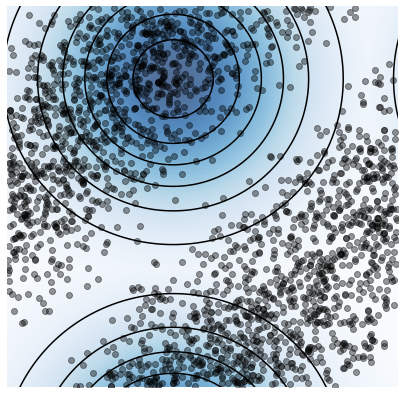

In [25]:
fig, ax = vis_utils.visualize_distribution(model, dmae_loss, 10, X, figsize=(7, 7))
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])